# New dataset
Find new dataset

In [2]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2


In [3]:
!pip install -r ../requirements.txt

# Imports

In [4]:
import numpy as np
import keras
from keras.datasets import cifar10
from __future__ import print_function
from keras.models import Sequential
from keras.models import load_model #save and load models
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import keras.backend as K
K.clear_session()

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
# from model import Mamba, ModelArgs  # Import your custom Mamba implementation
# Assuming the model classes are defined in `model.py`
from model import ImageMamba, ModelArgs

/Users/cagriatik/MAMBARIS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [16]:
# Load CIFAR-10 data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Reshape and preprocess the CIFAR-10 dataset for PyTorch models
X_train = X_train.transpose(0, 3, 1, 2)  # Shape: (batch_size, channels, height, width)
X_test = X_test.transpose(0, 3, 1, 2)

# Convert data to float and normalize pixel values in the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert the train/test data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# Your existing train loader code
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Add test loader
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Note: shuffle=False for test data

# Defining the model

In [6]:
# Define model parameters
d_model = 64
n_layer = 4
num_classes = 10  # CIFAR-10 has 10 classes

# Create an instance of ModelArgs
model_args = ModelArgs(d_model=d_model, n_layer=n_layer, vocab_size=0)  # vocab_size is unused here

# Instantiate the ImageMamba model
model = ImageMamba(model_args, num_classes=num_classes)

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ImageMamba(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layers): ModuleList(
    (0-3): 4 x ImageResidualBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (norm_f): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/Users/cagriatik/MAMBARIS/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training MAMBA on CIFAR10

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        logits, probabilities = model(inputs)  # Unpack the logits and probabilities

        # Flatten labels if they are not already
        labels = labels.view(-1)  # Flatten the labels to [batch_size]

        # Compute loss
        loss = criterion(logits, labels)  # Use logits for loss computation

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

/Users/cagriatik/MAMBARIS/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

## Evaluating the model + testing inference

In [ ]:
# Define the unique class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Switch to evaluation mode
model.eval()
y_pred = []
y_true = []
y_prob = []  # List to store probabilities

# Test the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_dataset:  # Use test_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on the test set: {accuracy:.4f}')

# Convert probabilities to percentages
y_prob_percentages = np.array(y_prob) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages):")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_percentages[i][class_index]:.2f}%")

# Switch to evaluation mode for training data
model.eval()
y_pred_train = []
y_true_train = []
y_prob_train = []  # List to store probabilities

# Test the model on training data
with torch.no_grad():
    for inputs, labels in train_dataset:  # Use train_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred_train.extend(predicted.cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())
        y_prob_train.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy on training data
accuracy_train = accuracy_score(y_true_train, y_pred_train)
print(f'Accuracy on the training set: {accuracy_train:.4f}')

# Convert probabilities to percentages
y_prob_train_percentages = np.array(y_prob_train) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages) for training data:")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true_train[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_train_percentages[i][class_index]:.2f}%")

In [ ]:
# Extract probabilities for the correct class on the test data
correct_class_probs_test = [y_prob[i][y_true[i]] for i in range(len(y_true))]
average_prob_correct_class_test = np.mean(correct_class_probs_test)
print(f'Average probability for the correct class on the test data: {average_prob_correct_class_test:.4f}')

# Extract probabilities for the correct class on the training data
correct_class_probs_train = [y_prob_train[i][y_true_train[i]] for i in range(len(y_true_train))]
average_prob_correct_class_train = np.mean(correct_class_probs_train)
print(f'Average probability for the correct class on the training data: {average_prob_correct_class_train:.4f}')

# Try 2, more epochs
As we can see there is not much difference between the probabilities of true class predictions on the traindataset instances, and the testdataset instances.

This might indicate that the dataset was hard easy for 10 epochs, lets add 15 more epochs, to get to a total of 25 epochs

In [ ]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
 
        # Forward pass
        logits, probabilities = model(inputs)  # Unpack the logits and probabilities

        # Flatten labels if they are not already
        labels = labels.view(-1)  # Flatten the labels to [batch_size]

        # Compute loss
        loss = criterion(logits, labels)  # Use logits for loss computation

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

In [ ]:
# Switch to evaluation mode
model.eval()
y_pred = []
y_true = []
y_prob = []  # List to store probabilities

# Test the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_dataset:  # Use test_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on the test set: {accuracy:.4f}')

# Convert probabilities to percentages
y_prob_percentages = np.array(y_prob) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages):")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_percentages[i][class_index]:.2f}%")

# Switch to evaluation mode for training data
model.eval()
y_pred_train = []
y_true_train = []
y_prob_train = []  # List to store probabilities

# Test the model on training data
with torch.no_grad():
    for inputs, labels in train_dataset:  # Use train_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred_train.extend(predicted.cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())
        y_prob_train.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy on training data
accuracy_train = accuracy_score(y_true_train, y_pred_train)
print(f'Accuracy on the training set: {accuracy_train:.4f}')

# Convert probabilities to percentages
y_prob_train_percentages = np.array(y_prob_train) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages) for training data:")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true_train[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_train_percentages[i][class_index]:.2f}%")

In [ ]:
# Extract probabilities for the correct class on the test data
correct_class_probs_test = [y_prob[i][y_true[i]] for i in range(len(y_true))]
average_prob_correct_class_test = np.mean(correct_class_probs_test)
print(f'Average probability for the correct class on the test data: {average_prob_correct_class_test:.4f}')

# Extract probabilities for the correct class on the training data
correct_class_probs_train = [y_prob_train[i][y_true_train[i]] for i in range(len(y_true_train))]
average_prob_correct_class_train = np.mean(correct_class_probs_train)
print(f'Average probability for the correct class on the training data: {average_prob_correct_class_train:.4f}')

As we see still no significant diffirence, lets make a stronger model, and train more epochs to achieve a loss close to 0, and then try inference again:

# Try 3, complex model
To get a much lower loss, we will both increase the number of epochs and make the model more complex.

In [ ]:
# Define model parameters
d_model = 128
n_layer = 8
num_classes = 10  # CIFAR-10 has 10 classes

# Create an instance of ModelArgs
model_args = ModelArgs(d_model=d_model, n_layer=n_layer, vocab_size=0)  # vocab_size is unused here

# Instantiate the ImageMamba model
complex_model = ImageMamba(model_args, num_classes=num_classes)

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
complex_model.to(device)

In [ ]:
# Training loop
num_epochs = 25 
for epoch in range(num_epochs):
    complex_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        logits, probabilities = complex_model(inputs)  # Unpack the logits and probabilities

        # Flatten labels if they are not already
        labels = labels.view(-1)  # Flatten the labels to [batch_size]

        # Compute loss
        loss = criterion(logits, labels)  # Use logits for loss computation

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

Here we will do 25 more, to have a total of 50 epochs.

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(complex_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    complex_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        logits, probabilities = complex_model(inputs)  # Unpack the logits and probabilities

        # Flatten labels if they are not already
        labels = labels.view(-1)  # Flatten the labels to [batch_size]

        # Compute loss
        loss = criterion(logits, labels)  # Use logits for loss computation

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Ai 

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

class TrainingMetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        self.train_confidences = []
        self.test_confidences = []
        self.confidence_gaps = []
        self.epoch_train_confidences = []  # Store all confidence values for each epoch
        self.epoch_test_confidences = []

    def update(self, train_loss, test_loss, train_acc, test_acc, 
              train_conf, test_conf, train_epoch_confs, test_epoch_confs):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        self.train_accuracies.append(train_acc)
        self.test_accuracies.append(test_acc)
        self.train_confidences.append(train_conf)
        self.test_confidences.append(test_conf)
        self.confidence_gaps.append(train_conf - test_conf)
        self.epoch_train_confidences.append(train_epoch_confs)
        self.epoch_test_confidences.append(test_epoch_confs)

    def plot_metrics(self, save_path=None):
        epochs = range(1, len(self.train_losses) + 1)
        
        # Create a figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot Loss
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.plot(epochs, self.test_losses, 'r-', label='Test Loss')
        ax1.set_title('Loss over Epochs')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot Accuracy
        ax2.plot(epochs, self.train_accuracies, 'b-', label='Training Accuracy')
        ax2.plot(epochs, self.test_accuracies, 'r-', label='Test Accuracy')
        ax2.set_title('Accuracy over Epochs')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        # Plot Confidence
        ax3.plot(epochs, self.train_confidences, 'b-', label='Training Confidence')
        ax3.plot(epochs, self.test_confidences, 'r-', label='Test Confidence')
        ax3.set_title('Average Confidence over Epochs')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Confidence')
        ax3.legend()
        ax3.grid(True)

        # Plot Confidence Gap
        ax4.plot(epochs, self.confidence_gaps, 'g-', label='Confidence Gap')
        ax4.set_title('Confidence Gap over Epochs')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Gap (Train - Test)')
        ax4.legend()
        ax4.grid(True)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def plot_confidence_distributions(self, epoch):
        """Plot confidence distributions for a specific epoch"""
        plt.figure(figsize=(10, 6))
        
        # Create density plots
        sns.kdeplot(data=self.epoch_train_confidences[epoch], label='Training', color='blue')
        sns.kdeplot(data=self.epoch_test_confidences[epoch], label='Test', color='red')
        
        plt.title(f'Confidence Distributions (Epoch {epoch+1})')
        plt.xlabel('Confidence')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()

    def statistical_tests(self, epoch=-1):
        """Perform statistical tests on confidence distributions"""
        if epoch == -1:
            epoch = len(self.epoch_train_confidences) - 1

        train_conf = self.epoch_train_confidences[epoch]
        test_conf = self.epoch_test_confidences[epoch]

        # Kolmogorov-Smirnov test
        ks_stat, ks_pval = stats.ks_2samp(train_conf, test_conf)
        
        # Mann-Whitney U test
        mw_stat, mw_pval = stats.mannwhitneyu(train_conf, test_conf, alternative='two-sided')
        
        # Effect size (Cohen's d)
        cohens_d = (np.mean(train_conf) - np.mean(test_conf)) / np.sqrt(
            (np.var(train_conf) + np.var(test_conf)) / 2)

        return {
            'ks_test': {'statistic': ks_stat, 'p_value': ks_pval},
            'mw_test': {'statistic': mw_stat, 'p_value': mw_pval},
            'cohens_d': cohens_d
        }

In [12]:
# In both the training loop and evaluation function, we need to detach tensors before converting to numpy

def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    confidence_sum = 0
    all_confidences = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1)
            
            logits, probabilities = model(inputs)
            loss = criterion(logits, labels)
            
            _, predicted = torch.max(logits, 1)
            confidence, _ = torch.max(probabilities, 1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
            confidence_sum += confidence.sum().item()
            all_confidences.extend(confidence.detach().cpu().numpy())  # Fixed here
    
    accuracy = (correct / total) * 100
    avg_loss = total_loss / len(data_loader)
    avg_confidence = confidence_sum / total
    
    return accuracy, avg_loss, avg_confidence, all_confidences

Epoch [1/2]
  Training:
    Loss: 1.4128
    Accuracy: 50.22%
    Average Confidence: 0.4167
  Testing:
    Loss: 1.3802
    Accuracy: 51.31%
    Average Confidence: 0.4751
--------------------------------------------------
Epoch [2/2]
  Training:
    Loss: 1.2779
    Accuracy: 55.31%
    Average Confidence: 0.4848
  Testing:
    Loss: 1.2952
    Accuracy: 53.77%
    Average Confidence: 0.5104
--------------------------------------------------


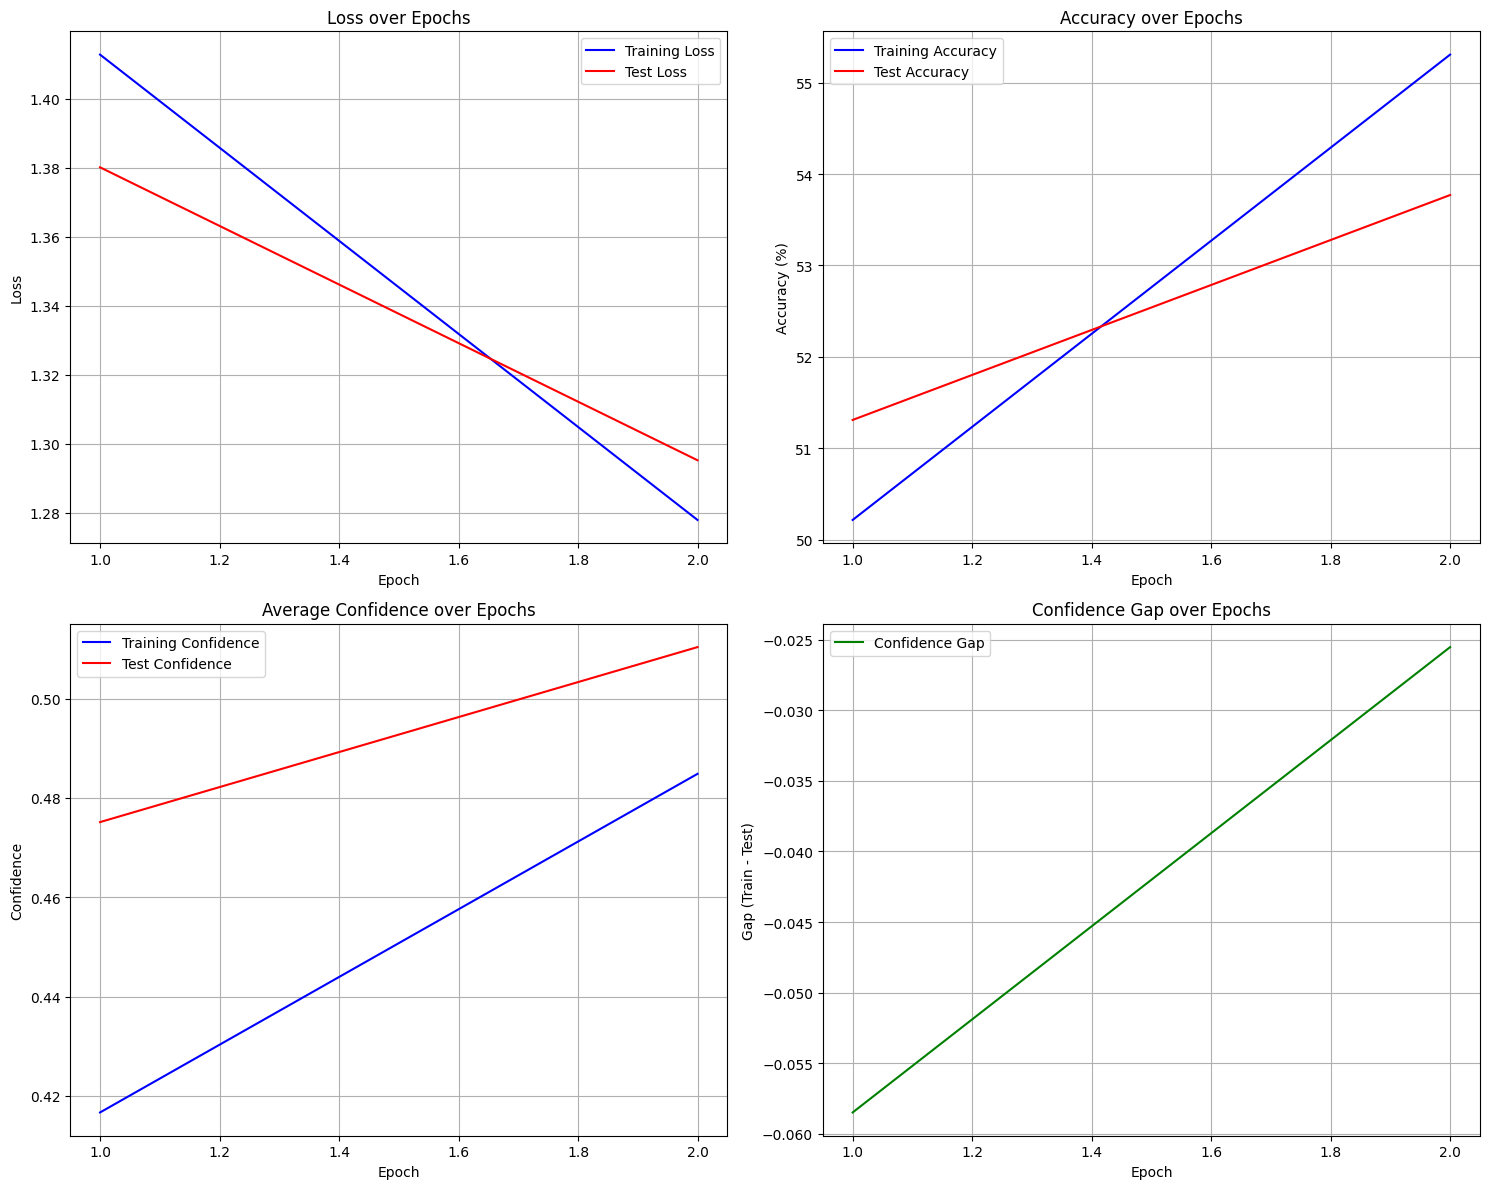

In [17]:
# Initialize metrics tracker
metrics_tracker = TrainingMetricsTracker()

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0
    train_confidence_sum = 0
    train_epoch_confidences = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)

        logits, probabilities = model(inputs)
        loss = criterion(logits, labels)

        _, predicted = torch.max(logits, 1)
        confidence, _ = torch.max(probabilities, 1)
        running_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        train_confidence_sum += confidence.sum().item()
        train_epoch_confidences.extend(confidence.detach().cpu().numpy())  # Fixed here

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = (running_correct / total_samples) * 100
    train_avg_confidence = train_confidence_sum / total_samples

    # Evaluate on test set
    test_accuracy, test_loss, test_avg_confidence, test_epoch_confidences = evaluate_model(model, test_loader, device)

    # Update metrics tracker
    metrics_tracker.update(
        train_loss, test_loss,
        train_accuracy, test_accuracy,
        train_avg_confidence, test_avg_confidence,
        train_epoch_confidences, test_epoch_confidences
    )

    # Print metrics
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'  Training:')
    print(f'    Loss: {train_loss:.4f}')
    print(f'    Accuracy: {train_accuracy:.2f}%')
    print(f'    Average Confidence: {train_avg_confidence:.4f}')
    print(f'  Testing:')
    print(f'    Loss: {test_loss:.4f}')
    print(f'    Accuracy: {test_accuracy:.2f}%')
    print(f'    Average Confidence: {test_avg_confidence:.4f}')
    
    # Perform statistical tests every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("\nStatistical Tests:")
        stats_results = metrics_tracker.statistical_tests(epoch)
        print(f"  Kolmogorov-Smirnov test:")
        print(f"    Statistic: {stats_results['ks_test']['statistic']:.4f}")
        print(f"    p-value: {stats_results['ks_test']['p_value']:.4f}")
        print(f"  Mann-Whitney U test:")
        print(f"    Statistic: {stats_results['mw_test']['statistic']:.4f}")
        print(f"    p-value: {stats_results['mw_test']['p_value']:.4f}")
        print(f"  Cohen's d: {stats_results['cohens_d']:.4f}")
        
        # Plot confidence distributions
        metrics_tracker.plot_confidence_distributions(epoch)
    
    print('-' * 50)

# After training, plot all metrics
metrics_tracker.plot_metrics(save_path='training_metrics.png')